# Pre Test set

x is 224 and y is 224 and z is 11
(50176, 11)


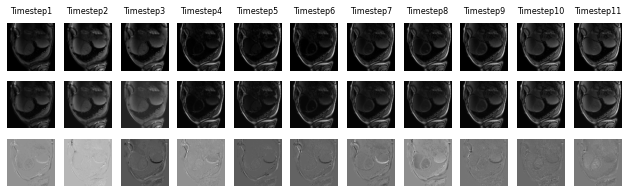

In [1]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from hyperspy.learn.rpca import rpca_godec, orpca
path = 'data/MOLLI_pre_dataset/test/0387056_20140423_MOLLI_3.npy'
vols = np.load(path).transpose(1, 2, 0)
x, y, z = vols.shape
print(f"x is {x} and y is {y} and z is {z}")
M = vols.reshape(x*y, z)
print(M.shape)
low, sparse, U, S, V = rpca_godec(M, rank=5)
low_matrix = low.reshape((x, y, z))
sparse_matrix = sparse.reshape((x, y, z))

fig = plt.figure(figsize=(11, 3))
title_font_size=8
title_pad = 10
for i in range(z):
    ax1 = fig.add_subplot(3, 11, 1+i)
    plt.imshow(vols[..., i], cmap='gray')
    plt.axis('off')
    ax1.set_title(f"Timestep{i+1}", fontsize=title_font_size, pad=title_pad)

    ax2 = fig.add_subplot(3, 11, 12+i)
    plt.imshow(low_matrix[..., i], cmap='gray')
    plt.axis('off')

    ax3 = fig.add_subplot(3, 11, 23+i)
    plt.imshow(sparse_matrix[..., i], cmap='gray')
    plt.axis('off')

## Test Metrics

In [2]:
rank = "10_5_3"

### Original volume

#### First Eigen Component percentage

In [3]:
from scripts.utils import *
orig_path = 'data/MOLLI_pre_dataset/test'
orig_pca_changes = []
for file in sorted(glob.glob(os.path.join(orig_path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    orig_pca_changes.append(org_dis)
print(f"Mean of original PCA is {np.mean(np.array(orig_pca_changes))}")

Mean of original PCA is 0.7867720274668718


#### T1 fitting

Mean of t1err is 11.072921129848977 and std is 4.963850319538608
Mean of t1err is 14.217012343355398 and std is 7.345939012337131


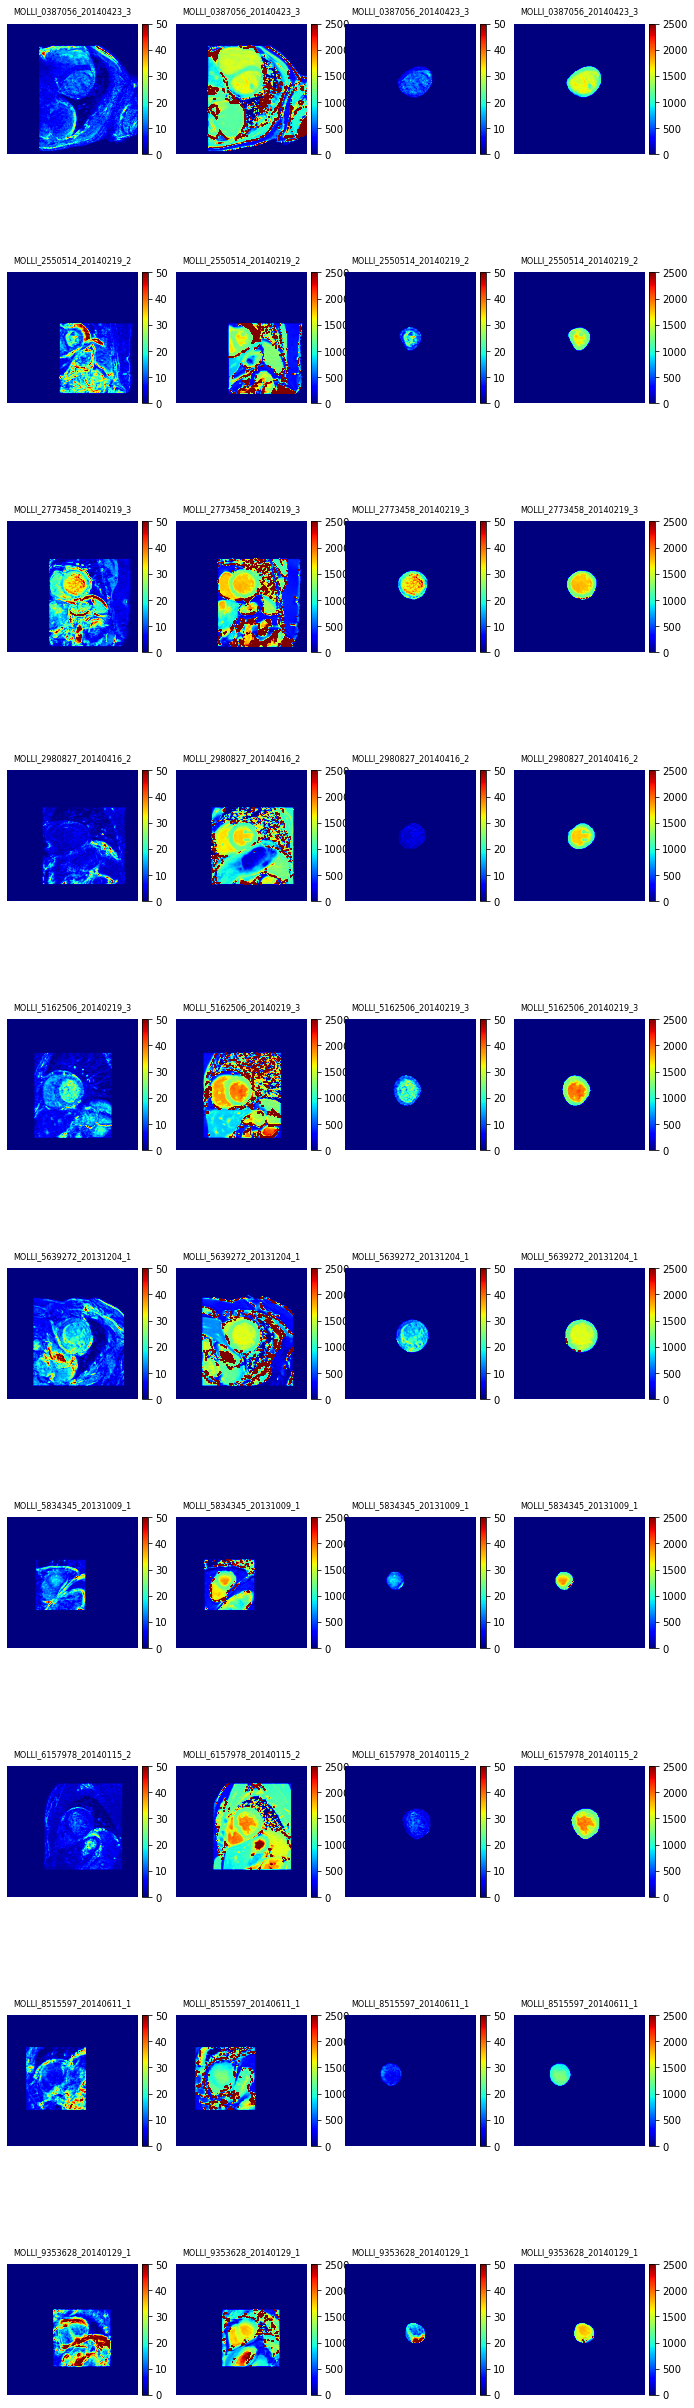

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
path = "data/MOLLI_pre_dataset/T1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
orig_t1err_square_list = []
orig_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    orig_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    orig_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_square_list))} and std is {np.std(np.array(orig_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(orig_t1err_heart_list))} and std is {np.std(np.array(orig_t1err_heart_list))}")
plt.savefig(f"data/MOLLI_pre_dataset/T1_SDerr/orig_t1err.png", dpi=300)

### Round 1

In [5]:
import voxelmorph_group as vxm  # nopep8
import numpy as np
import glob
import os
jacobian = vxm.losses.Jacobian().loss

#### First Eigen Component percentage

In [6]:
r = 1
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/moved"
r1_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r1_pca_changes.append(org_dis)
print(f"Mean of Round 1 PCA is {np.mean(np.array(r1_pca_changes))} and std is {np.std(np.array(r1_pca_changes))}")

Mean of Round 1 PCA is 0.8110349238781508 and std is 0.024050431691144368


#### Jacobian Determination

In [7]:
r1_folding_ratio_list = []
r1_mag_det_jac_det_list = []
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r1_folding_ratio_list.append(folding_ratio)
    r1_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r1_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r1_mag_det_jac_det_list))}")

Mean of folding ratio is 2.735824443413729e-05
Mean of mag det jac det is 0.00804909411817789


#### T1 fitting

Mean of t1err is 9.414453562974193 and std is 4.021877098048852
Mean of t1err is 13.36535606650404 and std is 6.482457930805934


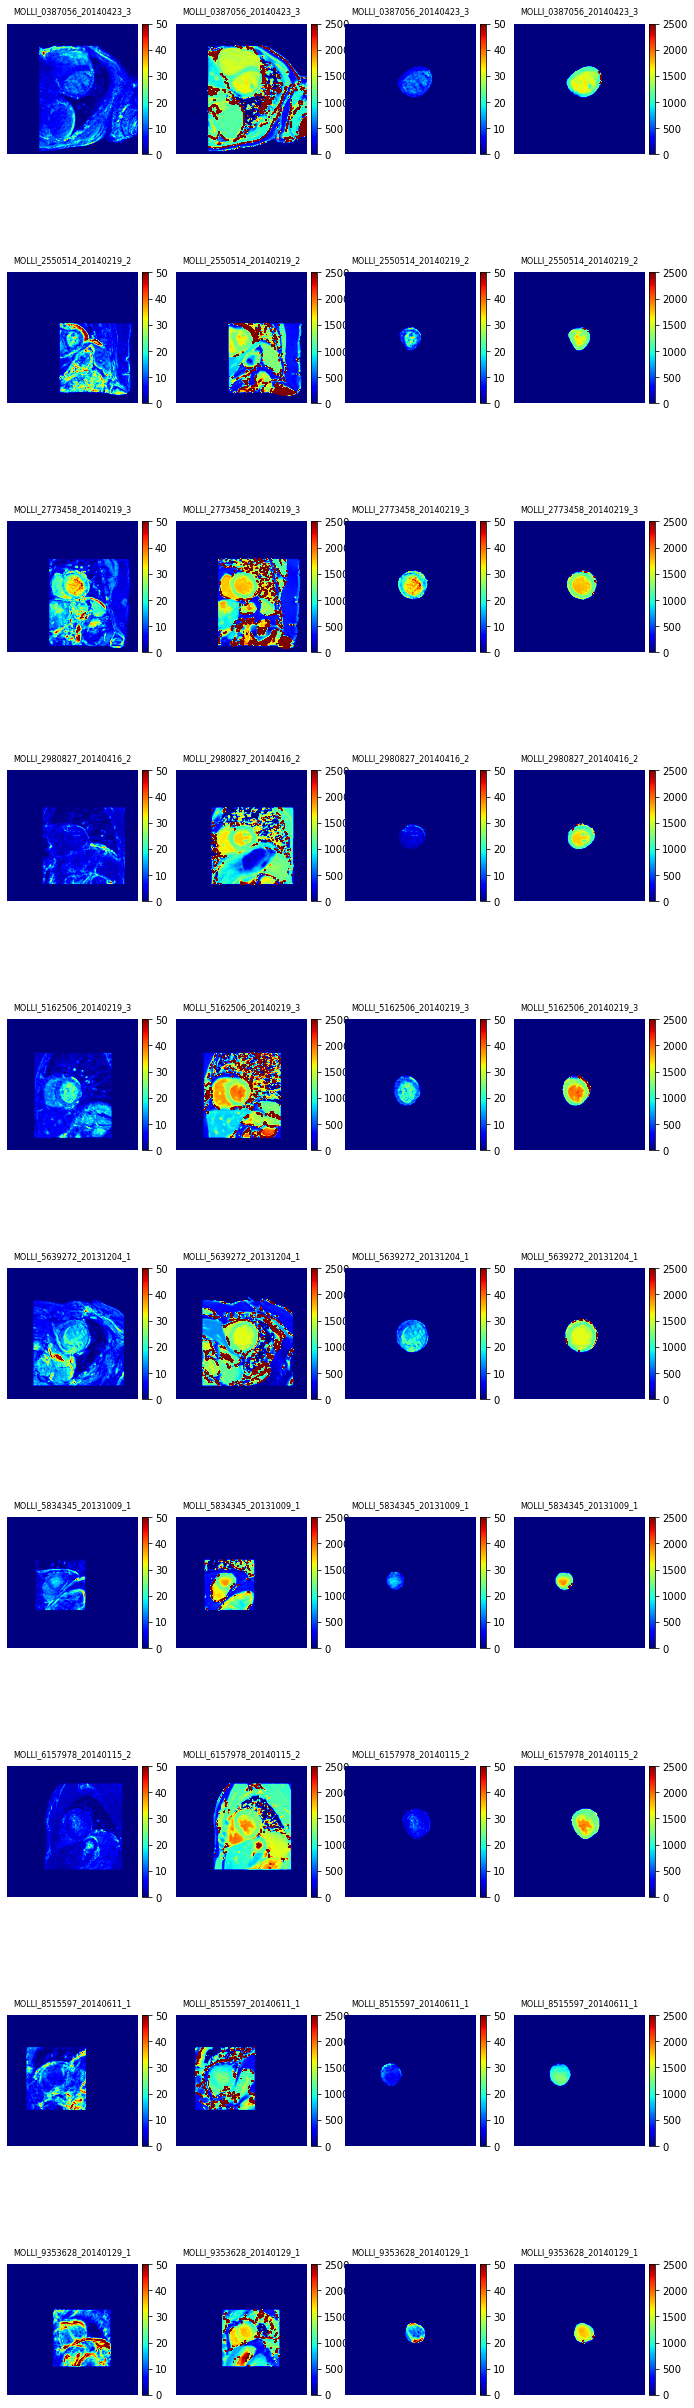

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
r = 1
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r1_t1err_square_list = []
r1_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r1_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r1_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_square_list))} and std is {np.std(np.array(r1_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r1_t1err_heart_list))} and std is {np.std(np.array(r1_t1err_heart_list))}")
plt.savefig(f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr.png", dpi=300)

### Round 2

#### First Eigen Component percentage

In [9]:
r = 2
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/moved"
r2_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r2_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r2_pca_changes))} and std is {np.std(np.array(r2_pca_changes))}")

Mean of Round 2 PCA is 0.8374998176434488 and std is 0.028603418960396202


#### Jacobian Determination

In [10]:
r2_folding_ratio_list = []
r2_mag_det_jac_det_list = []
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r2_folding_ratio_list.append(folding_ratio)
    r2_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r2_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r2_mag_det_jac_det_list))}")

Mean of folding ratio is 8.53359809833024e-05
Mean of mag det jac det is 0.007680398412048817


#### T1 fitting

Mean of t1err is 8.525799414703322 and std is 3.6052252053934186
Mean of t1err is 12.523608043167373 and std is 5.833686164872154


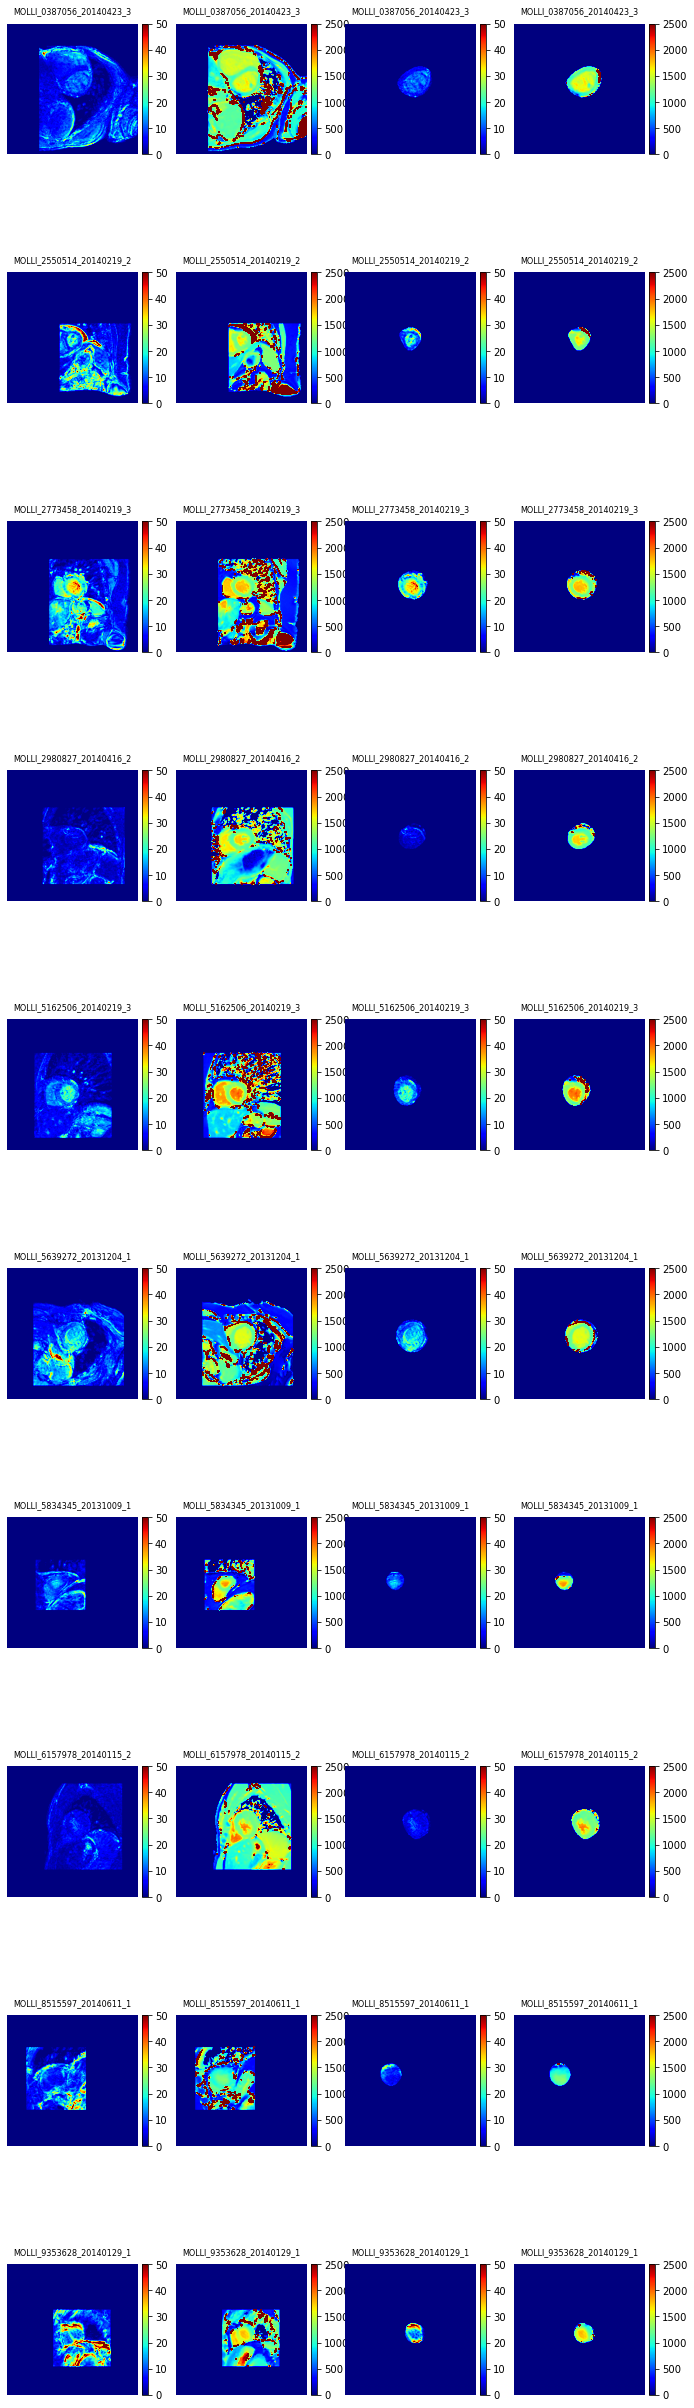

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
r = 2
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r2_t1err_square_list = []
r2_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r2_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r2_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_square_list))} and std is {np.std(np.array(r2_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r2_t1err_heart_list))} and std is {np.std(np.array(r2_t1err_heart_list))}")
plt.savefig(f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr.png", dpi=300)

### Round 3

#### First Eigen Component percentage

In [12]:
r = 3
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/moved"
r3_pca_changes = []
for file in sorted(glob.glob(os.path.join(path, '*.npy'))):
    vols = np.load(file).transpose(1, 2, 0)
    eig_org, org_K, org_dis = pca(vols, topk=1)
    r3_pca_changes.append(org_dis)
print(f"Mean of Round 2 PCA is {np.mean(np.array(r3_pca_changes))} and std is {np.std(np.array(r3_pca_changes))}")

Mean of Round 2 PCA is 0.8634800235858187 and std is 0.03538495208221749


#### Jacobian Determination

In [13]:
r3_folding_ratio_list = []
r3_mag_det_jac_det_list = []
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/warp"
for file in sorted(glob.glob(os.path.join(path, '*.nii'))):
    disp = vxm.py.utils.load_volfile(file).transpose(2, 3, 0, 1)
    folding_ratio, mag_det_jac_det = jacobian(disp)
    r3_folding_ratio_list.append(folding_ratio)
    r3_mag_det_jac_det_list.append(mag_det_jac_det)

print(f"Mean of folding ratio is {np.mean(np.array(r3_folding_ratio_list))}")
print(f"Mean of mag det jac det is {np.mean(np.array(r3_mag_det_jac_det_list))}")

Mean of folding ratio is 9.222083719851576e-05
Mean of mag det jac det is 0.00753798708319664


#### T1 fitting

Mean of t1err is 7.888790864354071 and std is 3.2957675715570964
Mean of t1err is 11.18167677286409 and std is 4.968834382461091


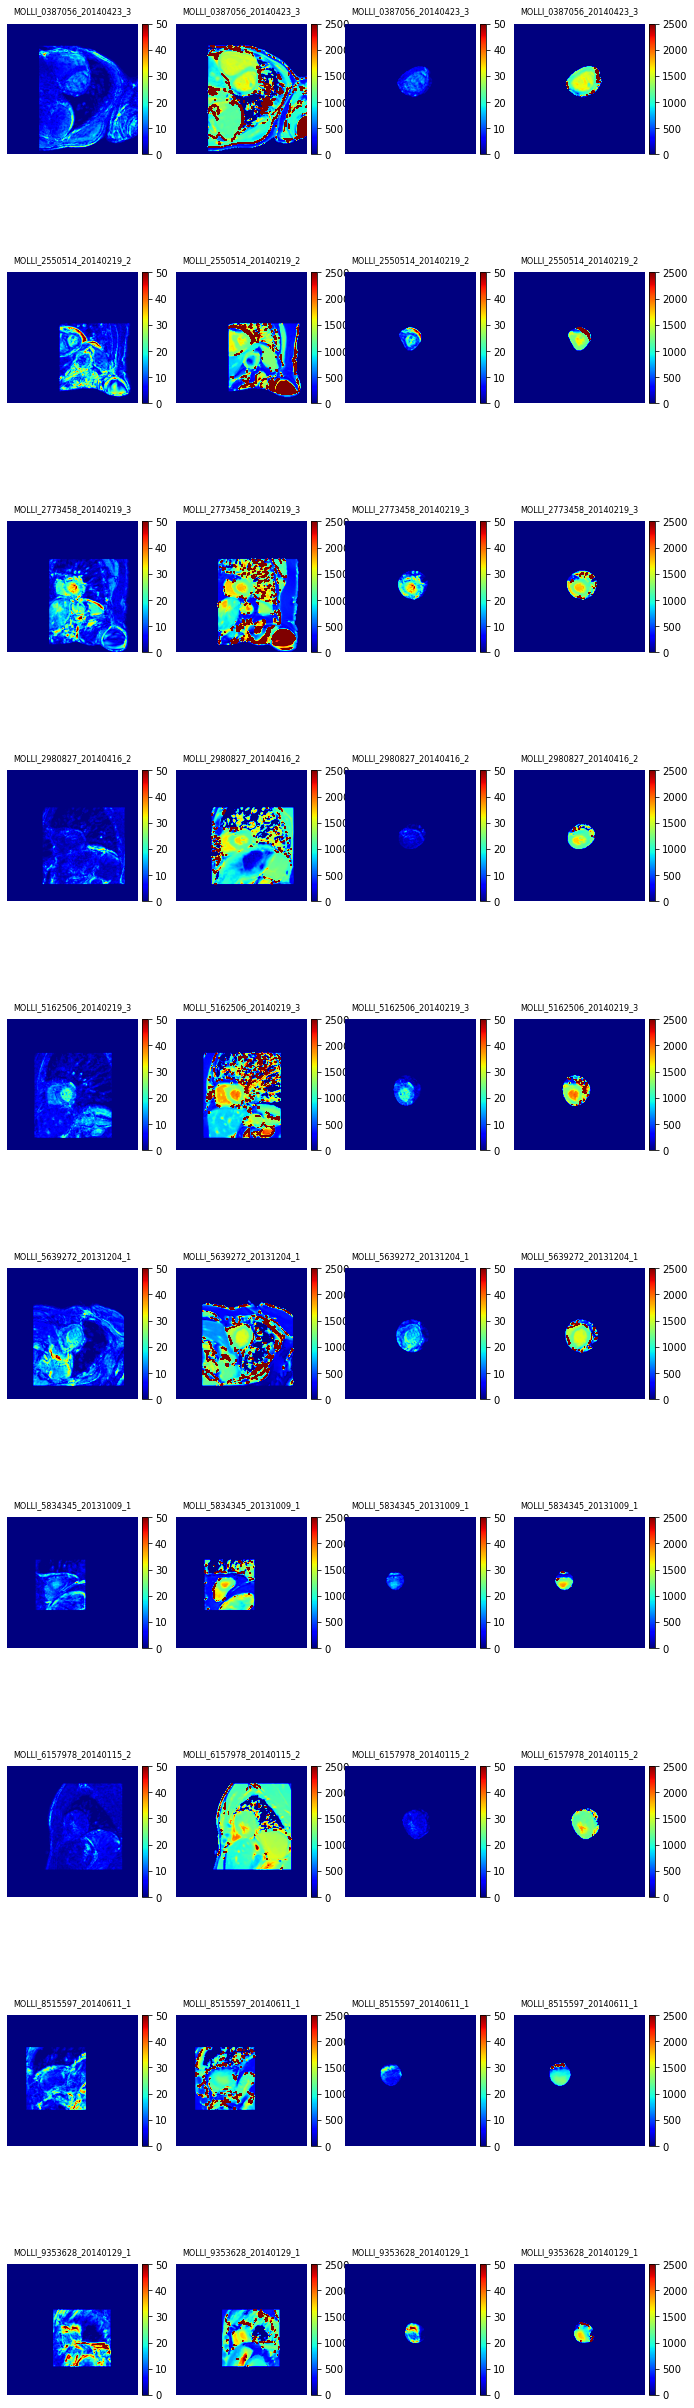

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.io
from pathlib import Path
# %matplotlib widget
r = 3
path = f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr"
# print(path)
fig = plt.figure(figsize=(10,40))
title_font_size=8
title_pad = 10
r3_t1err_square_list = []
r3_t1err_heart_list = []
subject_list = []
for i, file in enumerate(sorted(glob.glob(os.path.join(path, '*.mat')))):
    subject = Path(file).stem
    subject_list.append(subject)
    fd = scipy.io.loadmat(file)
    SD_err = fd['S']
    areamask = fd['areamask']
    heartmask = fd['epi_BW']
    errmap = SD_err * areamask

    r3_t1err_square_list.append(np.mean(errmap[areamask==1]))
    fig.add_subplot(10, 4, 1+i*4)
    ax = plt.gca()
    im = ax.imshow(errmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    t1_params_pre = fd['pmap_mse']
    a = t1_params_pre[:, :, 0]
    b = t1_params_pre[:, :, 1]
    c = t1_params_pre[:, :, 2]
    t1map = c * (b - 1)
    fig.add_subplot(10, 4, 2+i*4)
    ax = plt.gca()
    im = ax.imshow(t1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    hearterrmap = SD_err * heartmask
    heartt1map = t1map * heartmask
    r3_t1err_heart_list.append(np.mean(hearterrmap[heartmask==1]))

    fig.add_subplot(10, 4, 3+i*4)
    ax = plt.gca()
    im = ax.imshow(hearterrmap, cmap='jet', vmin=0, vmax=50)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

    fig.add_subplot(10, 4, 4+i*4)
    ax = plt.gca()
    im = ax.imshow(heartt1map, cmap='jet', vmin=0, vmax=2500)
    ax.axis('off')
    ax.set_title(f"{subject}", fontsize=title_font_size, pad=title_pad)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.subplots_adjust(left=0.0001,right=0.9, top=0.95, bottom=0.1,)
# plt.subplots_adjust(left=0.0001, right=0.99, top=0.9,
#                         bottom=0.1, wspace=0.01, hspace=0.2)
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_square_list))} and std is {np.std(np.array(r3_t1err_square_list))}")
print(f"Mean of t1err is {np.mean(np.array(r3_t1err_heart_list))} and std is {np.std(np.array(r3_t1err_heart_list))}")
plt.savefig(f"results/MOLLI_pre/group/rank_{rank}/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e80/test_MOLLI_pre/round{r}/t1_SDerr.png", dpi=300)

### Summary

In [15]:
import pandas as pd
df = pd.DataFrame()
df['Cases'] = subject_list
df['Raw Square T1err'] = orig_t1err_square_list
df['R1 Square T1err'] = r1_t1err_square_list
df['R2 Square T1err'] = r2_t1err_square_list
df['R3 Square T1err'] = r3_t1err_square_list
df['Square T1err diff'] = (df['Raw Square T1err'] - df['R3 Square T1err']) / df['Raw Square T1err']
df['Raw Heart T1err'] = orig_t1err_heart_list
df['R1 Heart T1err'] = r1_t1err_heart_list
df['R2 Heart T1err'] = r2_t1err_heart_list
df['R3 Heart T1err'] = r3_t1err_heart_list
df['Heart T1err diff'] = (df['Raw Heart T1err'] - df['R3 Heart T1err']) / df['Raw Heart T1err']
df

,Cases,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
0,MOLLI_0387056_20140423_3,7.539072,6.992616,6.621411,6.150152,0.184230,9.731935,9.324202,8.781546,7.886062,0.189672
1,MOLLI_2550514_20140219_2,12.360840,11.105049,10.167585,9.649756,0.219328,14.576425,14.303649,15.339527,17.014956,-0.167293
2,MOLLI_2773458_20140219_3,13.635501,11.468956,10.280366,9.344968,0.314659,28.671655,26.513011,22.387226,18.449894,0.356511
3,MOLLI_2980827_20140416_2,5.785524,4.892362,4.415486,4.188170,0.276095,3.958349,4.533334,4.289643,3.901168,0.014446
4,MOLLI_5162506_20140219_3,8.644283,7.443441,6.647432,5.909676,0.316349,17.141349,15.396112,12.665048,10.088040,0.411479
5,MOLLI_5639272_20131204_1,11.297461,9.597906,8.703820,8.029046,0.289305,17.010539,15.554680,13.702919,11.547681,0.321145
6,MOLLI_5834345_20131009_1,10.555566,8.304234,7.479178,7.021135,0.334840,12.637421,11.598732,11.014056,10.316061,0.183689
7,MOLLI_6157978_20140115_2,5.011841,4.313359,3.823888,3.581229,0.285446,6.933013,6.318900,5.189363,4.508544,0.349699
8,MOLLI_8515597_20140611_1,12.463286,10.860318,9.937035,9.283240,0.255153,7.736930,8.546160,9.909937,9.985084,-0.290574
9,MOLLI_9353628_20140129_1,23.435838,19.166296,17.181793,15.730536,0.328783,23.772507,21.564782,21.956817,18.119277,0.237805


In [16]:
df.describe()

,Raw Square T1err,R1 Square T1err,R2 Square T1err,R3 Square T1err,Square T1err diff,Raw Heart T1err,R1 Heart T1err,R2 Heart T1err,R3 Heart T1err,Heart T1err diff
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,11.072921,9.414454,8.525799,7.888791,0.280419,14.217012,13.365356,12.523608,11.181677,0.160658
std,5.232358,4.239431,3.800241,3.474044,0.048887,7.743300,6.833111,6.149245,5.237611,0.236321
min,5.011841,4.313359,3.823888,3.581229,0.184230,3.958349,4.533334,4.289643,3.901168,-0.290574
25%,7.815375,7.105322,6.627916,5.969795,0.260388,8.235682,8.740671,9.063644,8.410817,0.056757
50%,10.926513,8.951070,8.091499,7.525091,0.287376,13.606923,12.951190,11.839552,10.202050,0.213739
75%,12.437674,11.043867,10.109948,9.329536,0.315926,17.108646,15.515038,14.930375,15.648138,0.342561
max,23.435838,19.166296,17.181793,15.730536,0.334840,28.671655,26.513011,22.387226,18.449894,0.411479


In [17]:
df_2 = pd.DataFrame()
df_2['Cases'] = subject_list
df_2['Raw PCA'] = orig_pca_changes
df_2['R1 PCA'] = r1_pca_changes
df_2['R2 PCA'] = r2_pca_changes
df_2['R3 PCA'] = r3_pca_changes
df_2['R1 Det'] = r1_mag_det_jac_det_list
df_2['R2 Det'] = r2_mag_det_jac_det_list
df_2['R3 Det'] = r3_mag_det_jac_det_list
df_2['R1 Fold ratio'] = r1_folding_ratio_list
df_2['R2 Fold ratio'] = r2_folding_ratio_list
df_2['R3 Fold ratio'] = r3_folding_ratio_list
df_2

,Cases,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
0,MOLLI_0387056_20140423_3,0.806249,0.823766,0.839861,0.853101,0.007300,0.007334,0.005980,0.000000,0.000000,0.000000
1,MOLLI_2550514_20140219_2,0.792254,0.822854,0.870087,0.910667,0.008452,0.009367,0.008913,0.000000,0.000000,0.000000
2,MOLLI_2773458_20140219_3,0.773361,0.799971,0.832179,0.869125,0.007119,0.007177,0.007710,0.000065,0.000143,0.000178
3,MOLLI_2980827_20140416_2,0.813012,0.831274,0.851935,0.880304,0.008091,0.007419,0.008148,0.000076,0.000042,0.000710
4,MOLLI_5162506_20140219_3,0.787799,0.802919,0.815569,0.829884,0.007342,0.005767,0.005753,0.000000,0.000000,0.000000
5,MOLLI_5639272_20131204_1,0.773060,0.791105,0.805329,0.821348,0.007910,0.005827,0.006351,0.000000,0.000000,0.000000
6,MOLLI_5834345_20131009_1,0.757565,0.793562,0.837138,0.875454,0.008826,0.009278,0.009020,0.000132,0.000419,0.000034
7,MOLLI_6157978_20140115_2,0.839774,0.865681,0.895053,0.923810,0.008503,0.009286,0.008907,0.000000,0.000000,0.000000
8,MOLLI_8515597_20140611_1,0.770515,0.801392,0.835572,0.864057,0.009316,0.009666,0.008955,0.000000,0.000250,0.000000
9,MOLLI_9353628_20140129_1,0.754133,0.777825,0.792276,0.807049,0.007632,0.005683,0.005644,0.000000,0.000000,0.000000


In [18]:
df_2.describe()

,Raw PCA,R1 PCA,R2 PCA,R3 PCA,R1 Det,R2 Det,R3 Det,R1 Fold ratio,R2 Fold ratio,R3 Fold ratio
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.786772,0.811035,0.837500,0.863480,0.008049,0.007680,0.007538,0.000027,0.000085,0.000092
std,0.026789,0.025351,0.030151,0.037299,0.000723,0.001614,0.001452,0.000047,0.000144,0.000224
min,0.754133,0.777825,0.792276,0.807049,0.007119,0.005683,0.005644,0.000000,0.000000,0.000000
25%,0.771151,0.795165,0.819721,0.835688,0.007414,0.006164,0.006073,0.000000,0.000000,0.000000
50%,0.780580,0.802155,0.836355,0.866591,0.008001,0.007377,0.007929,0.000000,0.000000,0.000000
75%,0.802750,0.823538,0.848917,0.879092,0.008490,0.009284,0.008911,0.000049,0.000118,0.000026
max,0.839774,0.865681,0.895053,0.923810,0.009316,0.009666,0.009020,0.000132,0.000419,0.000710
